In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.chdir('/kaggle/input/facerecognition/facerecog/facerecognition')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer

from modelsrecog.face_recognition.model_small import create_model
from modelsrecog.face_recognition.align import AlignDlib
from triplet_loss import TripletLossLayer
from lfw_preprocessor import LfwDataGenerator


In [3]:
in_a = Input(shape=(96, 96, 3), name="img_a")
in_p = Input(shape=(96, 96, 3), name="img_p")
in_n = Input(shape=(96, 96, 3), name="img_n")

model_sm = create_model()

emb_a = model_sm(in_a)
emb_p = model_sm(in_p)
emb_n = model_sm(in_n)

triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

model = Model([in_a, in_p, in_n], triplet_loss_layer)

model.load_weights('ckpts/epochs006_loss0.379.hdf5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_a (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
img_p (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
img_n (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          2047216     img_a[0][0]                      
                                                                 img_p[0][0]                

In [4]:
base_model = model.layers[3]
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [5]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path, upper_limit):
    metadata = []
    count = 0
    for i in sorted(os.listdir(path)):
        if count == upper_limit: 
            break
            
        for f in sorted(os.listdir(os.path.join(path, i))):
            if count == upper_limit: 
                break
                
            count += 1
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]
    
def align_image(img):
        os.chdir('/kaggle/input/facerecognition/facerecog/facerecognition')
        alignment = AlignDlib('modelsrecog/landmarks.dat')
        bb = alignment.getLargestFaceBoundingBox(img)
        if bb is None:
            return cv2.resize(img, (96,96))
        else:
            return alignment.align(96, 
                                   img, 
                                   bb,
                                   landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

#This is the only modified method, its just load_metadata but for our class photos
#It also returns another list of strings (that contain the whose photos are who)
def load_metadataCOML(path):
    metadata = []
    nameList = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            #PNG files because our class dataset is in pngs
            ext = os.path.splitext(f)[1]
            if ext == '.png' or ext == '.png':
                metadata.append(IdentityMetadata(path, i, f))
                nameList.append(i)
    return np.array(metadata), nameList


In [6]:
#Practically the same as the slides
alignment = AlignDlib('modelsrecog/landmarks.dat')

metadataCOML, nameListCOML = load_metadataCOML('data/Face Photos Dataset')
embeddingsCOML = np.empty((metadataCOML.shape[0], 128))

print(len(metadataCOML))

for i, m in enumerate(metadataCOML):
    img = load_image(m.image_path())
    img = align_image(img)
    img = img.astype('float32')
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    embeddingsCOML[i] = base_model.predict(img)
    
    if i%1 == 0: print(i, end=" ")
    if i == len(metadataCOML)-1: print('done')

146
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 done


In [7]:
#nothing changed to this method
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#added the names of who is being compared by using nameListCOML
def show_pair(embeddingsCOML, id1, id2):
    plt.figure(figsize=(4,2))
    plt.suptitle(f'Distance = {distance(embeddingsCOML[id1], embeddingsCOML[id2]):.2f} of {nameListCOML[id1]} and {nameListCOML[id2]}')
    plt.subplot(1,2,1)
    plt.imshow(align_image(load_image(metadataCOML[id1].image_path())))
    plt.subplot(1,2,2)
    plt.imshow(align_image(load_image(metadataCOML[id2].image_path())))
    
def puttingImageInModelFileLocation(imgFileLocation):
    img = load_image(imgFileLocation)
    img = align_image(img)
    img = img.astype('float32')
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    embeddedImg = base_model.predict(img)
    
    return embeddedImg

def puttingImageInModel(img):
    img = align_image(img)
    img = img.astype('float32')
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    embeddedImg = base_model.predict(img)
    
    return embeddedImg

def embeddedImageArray(imagesCropped):
    embeddedImages = []
    for image in imagesCropped:
        embeddedImages.append(puttingImageInModel(np.asarray(image)))
    
    return embeddedImages


#Modified show_pair method to only take in one id, and an already existing embedded image.
#Shows distance between the two images
def show_pairModified(embeddingsCOML, embeddedImg, id2):
    plt.figure(figsize=(4,2))
    plt.suptitle(f'Distance = {distance(embeddedImg, embeddingsCOML[id2]):.2f} matches {nameListCOML[id2]}')
    plt.subplot(1,2,1)
    plt.imshow(align_image(load_image(newPhotoFileLocation)))
    plt.subplot(1,2,2)
    plt.imshow(align_image(load_image(metadataCOML[id2].image_path())))
#This method returns the best matching image's id (based on averages)

def calculateBestMatchAverages(emb1):
    
    minDistance = 999.0
    
    sumOfCurrentPersonDistance = distance(emb1, embeddingsCOML[0])
    entryCounter = 1
    currentBestMatchId = -1
    
    i = 0
    #basically a for loop
    while i < len(embeddingsCOML):
        distanceOfCurrentImg = distance(emb1, embeddingsCOML[i])

        if(i > 0):
            if(nameListCOML[i] == nameListCOML[i-1]):
                #If the person's name is the same as the previous img's name,
                #add to the sum of person's distances
                sumOfCurrentPersonDistance = sumOfCurrentPersonDistance + distanceOfCurrentImg
                entryCounter += 1
            else:
                #Resetting the sum of distances to the next persons
                #print(f'current average distance: {sumOfCurrentPersonDistance/entryCounter} when compared to {nameListCOML[i-1]}')
                if((sumOfCurrentPersonDistance/entryCounter) < minDistance):
                    minDistance = (sumOfCurrentPersonDistance/entryCounter)
                    #print(f'new best average distance: {sumOfCurrentPersonDistance/entryCounter} when compared to {nameListCOML[i-1]}')

                    currentBestMatchId = i - 1

                sumOfCurrentPersonDistance = distanceOfCurrentImg
                entryCounter = 1

            
            if(i == (len(embeddingsCOML) - 1)):
                if((sumOfCurrentPersonDistance/entryCounter) < minDistance):
                    minDistance = (sumOfCurrentPersonDistance/entryCounter)

                    currentBestMatchId = i


        #This print statement just shows you all the distances between all photos
        #Going to get rid of it later, its just here to show u how this works.
        #print(f'current distance: {distanceOfCurrentImg} when compared to {nameListCOML[i]}')
        i += 1

    return currentBestMatchId

#Same method as above but doesn't use averages
def calculateBestMatch(emb1, usedIDs):
    minDistance = 999.0
    
    currentBestMatchId = -1
    
    i = 0
    while i < len(embeddingsCOML):
        distanceOfCurrentImg = distance(emb1, embeddingsCOML[i])
        
        #If there is a distance that is lower, replace the current best match
        if((distanceOfCurrentImg < minDistance) and (findItemIDMapping(nameListCOML[i]) not in usedIDs)):
            minDistance = distanceOfCurrentImg
            currentBestMatch = i
        #print(f'current distance: {distanceOfCurrentImg} when compared to {nameListCOML[i]}')
        i += 1
    return currentBestMatch

IDList = ["Maria Amala Arasu", "Varun Ayyappan", "Rithvik Bobbili", "Jordan Chen", "Angela Cheng", "Timothy Clifford", "Antonio Farias", "Jonathan Ginsberg", "Jonathan Hayden", "Itai Iloni",
        "Changlin Jiang", "Nithin Joseph", "Joey Kim", "Victor Lee", "Joseph Lewis", "Justin Li", "Charvi Mayur", "Ayman Mohamed", "Harpreet Multani", "Ananya Nadig", "Alexandra O_Keeffe",
        "Jesuseyi Oyeyemi", "Nicholas Pangaro", "Rishi Papani", "Smit Patel", "Om Pathak", "Spencer Potter", "Faris Prasetiawan", "Ananya Ramanathan", "Varun Ramani", "Ian Roberts",
        "Sean Rountree", "Alexander Rubin", "Vasant Saladi", "Vrundal Manish Shah", "Matthew Snyder", "Aman Thanvi", "Atharv Trasi", "Rea Mariel Viray", "Richard Gao", "Jacob Ginzburg",
        "Siddhesh Gupta", "Siyao Li", "Rung_Chuan Lo", "Priyanka Mehta", "Siyuan Peng", "Sagar Saxena", "Allen Tu", "Derek Zhang"]


def findItemIDMapping(personsName):
    return IDList.index(personsName)

DETR portion


In [8]:
import os
os.chdir('/kaggle/input/detrfinal/completeDETR/detr')
print(os.getcwd())

/kaggle/input/detrfinal/completeDETR/detr


In [9]:
!pip install pycocotools

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272450 sha256=1fac304d805a5d4ffaa8e7cd3f0fee82491b5c134270288bb651a2c010ce3665
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [10]:
os.chdir('/kaggle/input/detrfinal/completeDETR/detr')
import argparse
import random
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import PIL.Image

import util.misc as utils
from models import build_model

from main import get_args_parser

In [11]:
parser = argparse.ArgumentParser(description = 'DETR args parser', parents = [get_args_parser()])
args = parser.parse_args(args=[])
args.resume = 'ckpts/checkpoint.pth'
args.device = 'cpu'

if args.output_dir:
  Path(args.output_dir).mkdir(parents = True, exist_ok = True)

args.distributed = False

print(args)

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, dataset_file='coco', dec_layers=6, device='cpu', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='ckpts/checkpoint.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)


In [12]:
model, criterion, postprocessors = build_model(args)

device = torch.device(args.device)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

In [13]:
output_dir = Path(args.output_dir)
if args.resume:
  if args.resume.startswith('https'):
    checkpoint = torch.hub.load_state_dict_from_url(
        args.resume, map_location = 'cpu', check_hash = True)
  else:
    checkpoint = torch.load(args.resume, map_location = 'cpu')

  model.load_state_dict(checkpoint['model'], strict = True)

In [14]:
# COCO classes
CLASSES = [
   'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
   'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
   'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
   'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
   'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
   'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
   'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
   'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
   'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
   'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
   'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
   'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
   'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
   'toothbrush'
]

In [15]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [16]:
def detect(im, model, transform):

  img = transform(im).unsqueeze(0)

  assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

  outputs = model(img)

  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.7

  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  return probas[keep], bboxes_scaled

In [17]:
def plot_results(pil_img, prob, boxes, classes):
  box = []
  plt.figure(figsize = (16, 10))
  plt.imshow(pil_img)
  ax = plt.gca()
  for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
    cl = p.argmax()
    if CLASSES[cl] not in classes:
      continue
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill = False, color = c, linewidth = 3))
    
    text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
    box.append([xmin, xmax, ymin, ymax])
    ax.text(xmin, ymin, text, fontsize = 15,
            bbox = dict(facecolor = 'yellow', alpha = 0.5))
  plt.axis('off')
  #plt.show()
  return box

In [18]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [19]:
import cv2
import sys
import json
import numpy as np
import shutil
from tqdm.notebook import tqdm


def widerface2coco(outputpath, image_root,json_name, annopath):
  dataset = { "info": {
              "description": "WIDER face in COCO format.",
              "url": "",
              "version": "1.1",
              "contributor": "aimhabo",
              "date_created": "2020-09-29"},
              "images": [],
              "annotations": [],
              "categories": [{"supercategory": "person", "id": 1, "name": "person"}, 
                             {"supercategory": "vehicle", "id": 2, "name": "bicycle"}, 
                             {"supercategory": "vehicle", "id": 3, "name": "car"}, 
                             {"supercategory": "vehicle", "id": 4, "name": "motorcycle"}, 
                             {"supercategory": "vehicle", "id": 5, "name": "airplane"}, 
                             {"supercategory": "vehicle", "id": 6, "name": "bus"}, 
                             {"supercategory": "vehicle", "id": 7, "name": "train"}, 
                             {"supercategory": "vehicle", "id": 8, "name": "truck"}, 
                             {"supercategory": "vehicle", "id": 9, "name": "boat"}, 
                             {"supercategory": "outdoor", "id": 10, "name": "traffic light"}, 
                             {"supercategory": "outdoor", "id": 11, "name": "fire hydrant"}, 
                             {"supercategory": "outdoor", "id": 13, "name": "stop sign"}, 
                             {"supercategory": "outdoor", "id": 14, "name": "parking meter"}, 
                             {"supercategory": "outdoor", "id": 15, "name": "bench"}, 
                             {"supercategory": "animal", "id": 16, "name": "bird"}, 
                             {"supercategory": "animal", "id": 17, "name": "cat"}, 
                             {"supercategory": "animal", "id": 18, "name": "dog"}, 
                             {"supercategory": "animal", "id": 19, "name": "horse"}, 
                             {"supercategory": "animal", "id": 20, "name": "sheep"}, 
                             {"supercategory": "animal", "id": 21, "name": "cow"}, 
                             {"supercategory": "animal", "id": 22, "name": "elephant"}, 
                             {"supercategory": "animal", "id": 23, "name": "bear"}, 
                             {"supercategory": "animal", "id": 24, "name": "zebra"}, 
                             {"supercategory": "animal", "id": 25, "name": "giraffe"}, 
                             {"supercategory": "accessory", "id": 27, "name": "backpack"}, 
                             {"supercategory": "accessory", "id": 28, "name": "umbrella"}, 
                             {"supercategory": "accessory", "id": 31, "name": "handbag"}, 
                             {"supercategory": "accessory", "id": 32, "name": "tie"}, 
                             {"supercategory": "accessory", "id": 33, "name": "suitcase"}, 
                             {"supercategory": "sports", "id": 34, "name": "frisbee"}, 
                             {"supercategory": "sports", "id": 35, "name": "skis"}, 
                             {"supercategory": "sports", "id": 36, "name": "snowboard"}, 
                             {"supercategory": "sports", "id": 37, "name": "sports ball"}, 
                             {"supercategory": "sports", "id": 38, "name": "kite"}, 
                             {"supercategory": "sports", "id": 39, "name": "baseball bat"}, 
                             {"supercategory": "sports", "id": 40, "name": "baseball glove"}, 
                             {"supercategory": "sports", "id": 41, "name": "skateboard"}, 
                             {"supercategory": "sports", "id": 42, "name": "surfboard"}, 
                             {"supercategory": "sports", "id": 43, "name": "tennis racket"}, 
                             {"supercategory": "kitchen", "id": 44, "name": "bottle"}, 
                             {"supercategory": "kitchen", "id": 46, "name": "wine glass"}, 
                             {"supercategory": "kitchen", "id": 47, "name": "cup"}, 
                             {"supercategory": "kitchen", "id": 48, "name": "fork"}, 
                             {"supercategory": "kitchen", "id": 49, "name": "knife"}, 
                             {"supercategory": "kitchen", "id": 50, "name": "spoon"}, 
                             {"supercategory": "kitchen", "id": 51, "name": "bowl"}, 
                             {"supercategory": "food", "id": 52, "name": "banana"}, 
                             {"supercategory": "food", "id": 53, "name": "apple"}, 
                             {"supercategory": "food", "id": 54, "name": "sandwich"}, 
                             {"supercategory": "food", "id": 55, "name": "orange"}, 
                             {"supercategory": "food", "id": 56, "name": "broccoli"}, 
                             {"supercategory": "food", "id": 57, "name": "carrot"}, 
                             {"supercategory": "food", "id": 58, "name": "hot dog"}, 
                             {"supercategory": "food", "id": 59, "name": "pizza"}, 
                             {"supercategory": "food", "id": 60, "name": "donut"}, 
                             {"supercategory": "food", "id": 61, "name": "cake"}, 
                             {"supercategory": "furniture", "id": 62, "name": "chair"}, 
                             {"supercategory": "furniture", "id": 63, "name": "couch"}, 
                             {"supercategory": "furniture", "id": 64, "name": "potted plant"}, 
                             {"supercategory": "furniture", "id": 65, "name": "bed"}, 
                             {"supercategory": "furniture", "id": 67, "name": "dining table"}, 
                             {"supercategory": "furniture", "id": 70, "name": "toilet"}, 
                             {"supercategory": "electronic", "id": 72, "name": "tv"}, 
                             {"supercategory": "electronic", "id": 73, "name": "laptop"}, 
                             {"supercategory": "electronic", "id": 74, "name": "mouse"}, 
                             {"supercategory": "electronic", "id": 75, "name": "remote"}, 
                             {"supercategory": "electronic", "id": 76, "name": "keyboard"}, 
                             {"supercategory": "electronic", "id": 77, "name": "cell phone"}, 
                             {"supercategory": "appliance", "id": 78, "name": "microwave"}, 
                             {"supercategory": "appliance", "id": 79, "name": "oven"}, 
                             {"supercategory": "appliance", "id": 80, "name": "toaster"}, 
                             {"supercategory": "appliance", "id": 81, "name": "sink"}, 
                             {"supercategory": "appliance", "id": 82, "name": "refrigerator"}, 
                             {"supercategory": "indoor", "id": 84, "name": "book"}, 
                             {"supercategory": "indoor", "id": 85, "name": "clock"}, 
                             {"supercategory": "indoor", "id": 86, "name": "vase"}, 
                             {"supercategory": "indoor", "id": 87, "name": "scissors"}, 
                             {"supercategory": "indoor", "id": 88, "name": "teddy bear"}, 
                             {"supercategory": "indoor", "id": 89, "name": "hair drier"}, 
                             {"supercategory": "indoor", "id": 90, "name": "toothbrush"}],
  }

  phase = json_name

  with open(annopath,'r') as f:
      lines = f.readlines()
      num_lines = len(lines)
      i_l=0
      img_id=1
      anno_id=1
      imagepath=None

      pbar = tqdm(total=num_lines)

      while i_l < num_lines:
          if len(lines[i_l]) < 1:
              break
          if '--' in lines[i_l]:
              imagepath=lines[i_l].strip()
              im=image_root+imagepath
              if (not os.path.exists(im)):
                print(im)
                break
              im = cv2.imread(im)
              height, width, channels = im.shape
              dataset["images"].append({"file_name": imagepath, "coco_url": "local", "height": height, "width": width, "flickr_url": "local", "id": img_id})
              i_l+=1
              pbar.update(1)
              num_gt=int(lines[i_l])
              while num_gt>0:
                  i_l+=1
                  pbar.update(1)
                  x1,y1,wid,hei=list(map(int, lines[i_l].split()))[:4]
                  num_gt-=1
                  dataset["annotations"].append({
                      "segmentation": [],
                      "iscrowd": 0,
                      "area": wid * hei,
                      "image_id": img_id,
                      "bbox": [x1, y1, wid, hei],
                      "category_id": 1,
                      "id": anno_id})
                  anno_id = anno_id + 1
                  #if im is not None:
                  #    cv2.rectangle(im,(x1,y1),(x1+wid,y1+hei), (0,0,0), 3)
                  #    cv2.rectangle(im,(x1,y1),(x1+wid,y1+hei), (255,255,255), 1)
              img_id+=1
              #if im is not None:
              #    cv2.imshow('img', im)
              #    cv2.waitKey(0)
          i_l+=1
          pbar.update(1)
          
      pbar.close()

  json_name = os.path.join(outputpath, "{}.json".format(phase))

  with open(json_name, 'w') as f:
      json.dump(dataset, f)

In [20]:


def getPersonBoundingBoxes(the_image):
    scores, boxes = detect(the_image, model, transform)

    plot_classes = ['person']
    box_id = plot_results(the_image, scores, boxes, plot_classes)
    
    return box_id
    

In [21]:
def getImageArray(the_image ,box_id):
    imagesCropped = []
    for i in box_id:
      imagesCropped.append(the_image.crop((i[0], i[2], i[1], i[3])))
    
    return imagesCropped


In [22]:
def plot_resultsWithNamesAndID(pil_img, prob, boxes, classes, imageEmbeddings, fileName):
    plt.figure(figsize = (16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    
    index = 0
    
    usedIDs = []

    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        cl = p.argmax()
        if CLASSES[cl] not in classes:
            continue
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill = False, color = c, linewidth = 3))


        currentBestMatchId = calculateBestMatch(embeddedImages[0], usedIDs)
        index += 1
    
        text = nameListCOML[currentBestMatchId]
        correspondingID = findItemIDMapping(nameListCOML[currentBestMatchId])
        usedIDs.append(correspondingID)
        fileID = (fileName + "_" + str(correspondingID))
        
        if fileID in IDsToFind and fileID not in usedIDsAllImg:
            usedIDsAllImg.append(fileID)
            writer.writerow([fileID, int(xmin), int(xmax), int(ymin), int(ymax)])
                        
        ax.text(xmin, ymin, text, fontsize = 15,
                bbox = dict(facecolor = 'yellow', alpha = 0.5))

    plt.axis('off')
    plt.show()


processing a.jpg


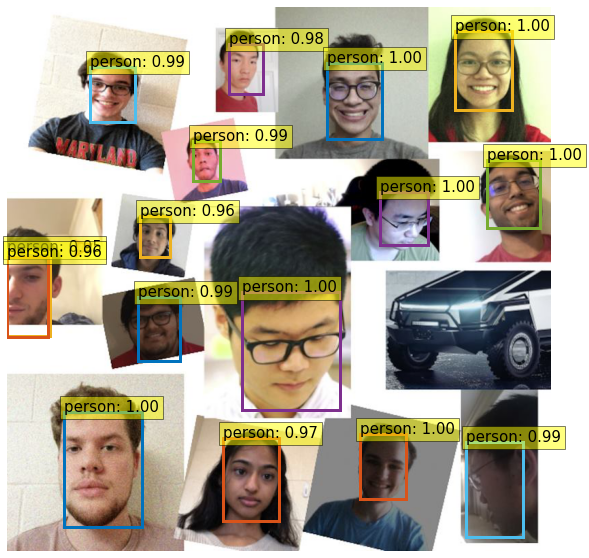

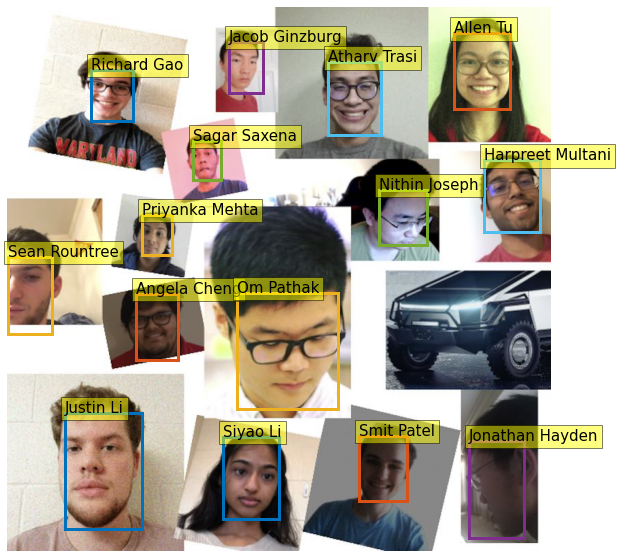

processing b.jpg


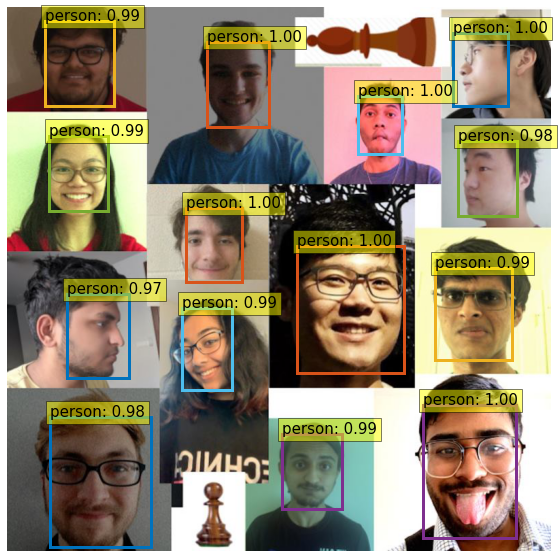

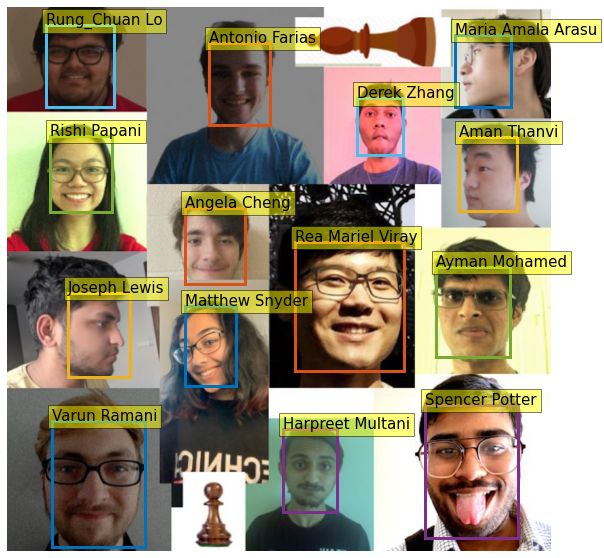

processing c.jpg


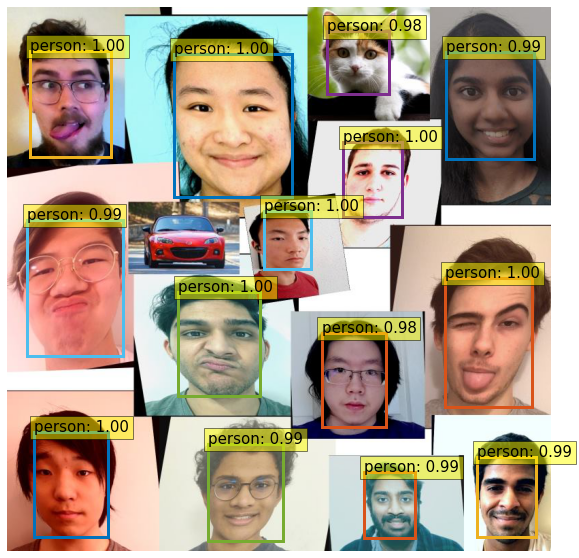

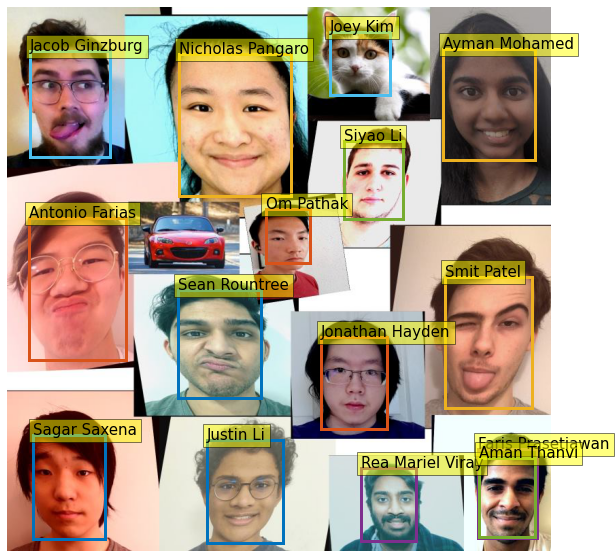

processing d.jpg


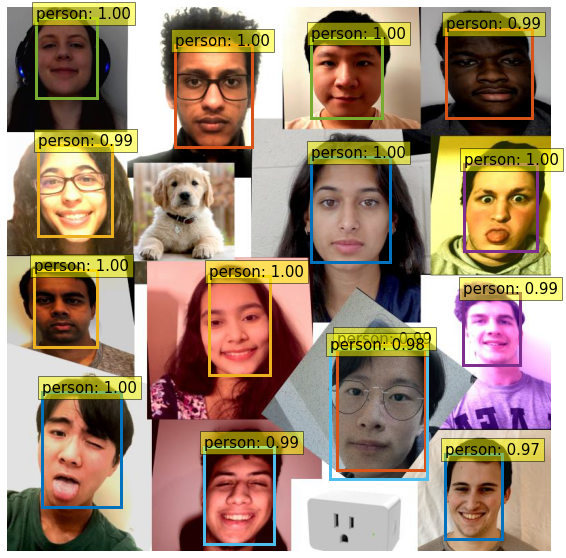

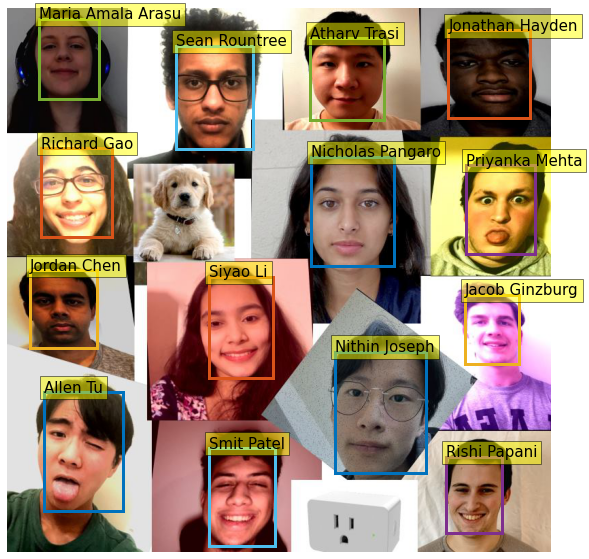

In [23]:
import csv

IDsToFind = ['a_43','a_32','a_47','a_48','a_40','a_28','a_37','a_27','a_30','a_36','a_45','a_25','a_38','a_35','a_46',
             'b_25','b_39','b_42','b_35','b_36','b_43','b_34','b_44','b_26','b_38','b_29','b_33','b_31','b_41',
             'c_47','c_12','c_0','c_4','c_9','c_14','c_15','c_22','c_11','c_23','c_2','c_24','c_13',
             'd_20','d_19','d_6','d_17','d_10','d_16','d_18','d_21','d_7','d_8','d_3','d_42','d_1','d_5']
usedIDsAllImg = []

submission = '/kaggle/working/submission.csv'
output_csv = open(submission, 'w')
output_csv.truncate(0)
writer = csv.writer(output_csv)

writer.writerow(['id', 'xmin', 'xmax', 'ymin', 'ymax'])
plot_classes = ['person']

print("processing a.jpg")
os.chdir('/kaggle/input/2021-spring-coml-face-recognition-competition')
the_image = PIL.Image.open('a.jpg')
embeddedImages = embeddedImageArray(getImageArray(the_image, getPersonBoundingBoxes(the_image)))
scores, boxes = detect(the_image, model, transform)
plot_resultsWithNamesAndID(the_image, scores, boxes, plot_classes, embeddedImages, 'a')

print("processing b.jpg")
os.chdir('/kaggle/input/2021-spring-coml-face-recognition-competition')
the_image = PIL.Image.open('b.jpg')
embeddedImages = embeddedImageArray(getImageArray(the_image, getPersonBoundingBoxes(the_image)))
scores, boxes = detect(the_image, model, transform)
plot_resultsWithNamesAndID(the_image, scores, boxes, plot_classes, embeddedImages, 'a')

print("processing c.jpg")
os.chdir('/kaggle/input/2021-spring-coml-face-recognition-competition')
the_image = PIL.Image.open('c.jpg')
embeddedImages = embeddedImageArray(getImageArray(the_image, getPersonBoundingBoxes(the_image)))
scores, boxes = detect(the_image, model, transform)
plot_resultsWithNamesAndID(the_image, scores, boxes, plot_classes, embeddedImages, 'a')

print("processing d.jpg")
os.chdir('/kaggle/input/2021-spring-coml-face-recognition-competition')
the_image = PIL.Image.open('d.jpg')
embeddedImages = embeddedImageArray(getImageArray(the_image, getPersonBoundingBoxes(the_image)))
scores, boxes = detect(the_image, model, transform)
plot_resultsWithNamesAndID(the_image, scores, boxes, plot_classes, embeddedImages, 'a')

for IDs in IDsToFind:
    if IDs not in usedIDsAllImg:
        writer.writerow([IDs, 0, 0, 0, 0])